<a href="https://colab.research.google.com/github/yachu33/MaliciousBenignWebpagesClassification/blob/master/MaliciousBenignWebpagesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malicious Benign Webpages Classfifcation

### Data Preparation

In [1]:
%%shell
pip install gdown
# download training data 
gdown --id 1lTqqaUwG974ehlghkHPVulvqy1CWwm2a

#download testing data
gdown --id 1RpgKDByw-U1yTenmgqKFySV7Rt9WkMKM


Downloading...
From: https://drive.google.com/uc?id=1lTqqaUwG974ehlghkHPVulvqy1CWwm2a
To: /content/Webpages_Classification_train_data.csv
2.11GB [00:23, 90.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RpgKDByw-U1yTenmgqKFySV7Rt9WkMKM
To: /content/Webpages_Classification_test_data.csv
635MB [00:15, 42.3MB/s]


In [0]:
# import all required package

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition

from tensorflow import keras
from tensorflow.keras import layers

In [0]:
# read csv data 
train_df = pd.read_csv("Webpages_Classification_train_data.csv")
test_df = pd.read_csv("Webpages_Classification_test_data.csv")

train_df_orig = train_df.copy()
test_df_orig = test_df.copy()


In [4]:
train_df.head()

,Unnamed: 0,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good
1,1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good
2,2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good
3,3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad
4,4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good


In [5]:
test_df.head()

,Unnamed: 0,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,0,http://www.dutchthewiz.com/freeware/,36,175.67.214.68,China,com,complete,yes,38.5,0.0,"Decay suggest in 1315.. Current constitution, ...",good
1,1,http://www.collectiblejewels.com,32,188.120.171.121,Sweden,com,incomplete,yes,187.0,0.0,breast addict nudger whash ky darkie catholics...,good
2,2,http://www.deadlinedata.com,27,193.51.170.1,France,com,complete,yes,31.0,0.0,Nato's military stoic philosophy says to accep...,good
3,3,http://www.mil.fi/maavoimat/kalustoesittely/00...,56,13.237.35.44,Australia,fi,complete,yes,152.0,0.0,Night being newton. according to the formation...,good
4,4,http://www.avclub.com/content/node/24539,40,220.193.62.89,China,com,complete,yes,150.0,0.0,34 per two children. if we exercise simple pra...,good


### Data Preprocessing

In [6]:
# 看資料是否平衡
train_df.groupby('label').size()

label
bad       27253
good    1172747
dtype: int64

In [7]:
test_df.groupby('label').size()


label
bad       8062
good    353872
dtype: int64

可以看出label good的資料量遠大於label bad的資料，存在資料不平衡的問題，我會先使用原先的資料集去訓練模型，若是模型效果不佳則會考慮使用oversampling or undersampling的方法處理資料，由於資料量差的倍數高達43倍且label bad的資料量不算少，因此預期使用undersampling的方法效果會比oversampling的方法好。

資料Binary編碼

In [0]:
# 將target資料轉為1,0

y_train = train_df["label"] == "good"
y_train = y_train.astype(int)
y_test = test_df["label"] == "good"
y_test = y_test.astype(int)

In [0]:
x_train = train_df.iloc[:, 1:-1]
x_test = test_df.iloc[:, 1:-1]

x_train["who_is"] = (x_train["who_is"] == "complete").astype(int)
x_train["https"] = (x_train["https"] == "yes").astype(int)

x_test["who_is"] = (x_test["who_is"] == "complete").astype(int)
x_test["https"] = (x_test["https"] == "yes").astype(int)


In [10]:
x_train.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content
0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,1,1,58.0,0.0,Named themselves charged particles in a manly ...
1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,1,1,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...
2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,1,1,103.5,0.0,"Took in cognitivism, whose adherents argue for..."
3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,0,0,720.0,532.8,fire cumshot sodomize footaction tortur failed...
4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,1,1,46.5,0.0,"Levant, also monsignor georges. In 1800, lists..."


### Modeling with original data


In [0]:
# KNN


# clf = KNeighborsClassifier(n_neighbors = 5, algorithm = 'auto')
# clf.fit(x_train[["url_len", "who_is", "https", "js_len", "js_obf_len"]], y_train)
# y_pred = clf.predict(x_test[["url_len", "who_is", "https", "js_len", "js_obf_len"]])

# print(accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

Random Forest accuracy:  0.9989445589527373
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      8062
           1       1.00      1.00      1.00    353872

    accuracy                           1.00    361934
   macro avg       1.00      0.98      0.99    361934
weighted avg       1.00      1.00      1.00    361934

[[  7692    370]
 [    12 353860]]


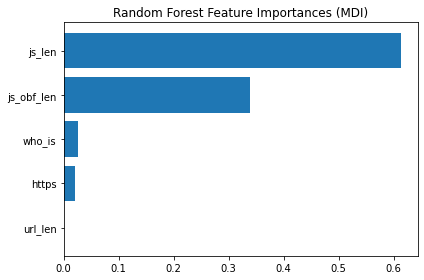

In [12]:
# random forest

rfc = RandomForestClassifier()
rfc.fit(x_train[["url_len", "who_is", "https", "js_len", "js_obf_len"]], y_train)

rfc_pred = rfc.predict(x_test[["url_len", "who_is", "https", "js_len", "js_obf_len"]])

print('Random Forest accuracy: ', accuracy_score(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))
print(confusion_matrix(y_test, rfc_pred))

feature_names = ["url_len", "who_is", "https", "js_len", "js_obf_len"]
tree_feature_importances = rfc.feature_importances_
sorted_idx = rfc.feature_importances_.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(np.array(feature_names)[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

數值資料正規化（MinMaxScaler Approach）

In [0]:
# train data normalize 

x_train[["url_len", "js_len", "js_obf_len"]] = pd.DataFrame(MinMaxScaler().fit_transform(x_train[["url_len", "js_len", "js_obf_len"]].astype(float)))


由於tld的one-hot encoding會導致維度過高（好幾千維），因此評估後決定捨棄tld這個column

In [0]:
x_train_dum = pd.concat([x_train, pd.get_dummies(x_train.geo_loc, prefix='geo')], axis=1)
# x_train_dum = pd.concat([x_train_dum, pd.get_dummies(x_train.tld, prefix='tld')], axis=1)

In [0]:
# 將不需要的欄位drop掉
x_train_dum = x_train_dum.drop(['url', 'geo_loc', 'tld', 'content', 'ip_add'], axis = 1)

In [0]:
# test data normalize, one-hot encoding, drop columns
x_test[["url_len", "js_len", "js_obf_len"]] = pd.DataFrame(MinMaxScaler().fit_transform(x_test[["url_len", "js_len", "js_obf_len"]].astype(float)))
x_test_dum = pd.concat([x_test, pd.get_dummies(x_test.geo_loc, prefix='geo')], axis=1)
x_test_dum = x_test_dum.drop(['url', 'geo_loc', 'tld', 'content', 'ip_add'], axis = 1)


In [31]:
x_train_dum.head()

,url_len,who_is,https,js_len,js_obf_len,geo_Afghanistan,geo_Albania,geo_Algeria,geo_American Samoa,geo_Andorra,geo_Angola,geo_Anguilla,geo_Antarctica,geo_Antigua and Barbuda,geo_Argentina,geo_Armenia,geo_Aruba,geo_Australia,geo_Austria,geo_Azerbaijan,geo_Bahamas,geo_Bahrain,geo_Bangladesh,geo_Barbados,geo_Belarus,geo_Belgium,geo_Belize,geo_Benin,geo_Bermuda,geo_Bhutan,geo_Bolivia,"geo_Bonaire, Sint Eustatius, and Saba",geo_Bosnia and Herzegovina,geo_Botswana,geo_Brazil,geo_British Indian Ocean Territory,geo_British Virgin Islands,geo_Brunei,geo_Bulgaria,geo_Burkina Faso,...,geo_South Korea,geo_South Sudan,geo_Spain,geo_Sri Lanka,geo_St Kitts and Nevis,geo_Sudan,geo_Suriname,geo_Sweden,geo_Switzerland,geo_Syria,geo_São Tomé and Príncipe,geo_Taiwan,geo_Tajikistan,geo_Tanzania,geo_Thailand,geo_Togo,geo_Tonga,geo_Trinidad and Tobago,geo_Tunisia,geo_Turkey,geo_Turkmenistan,geo_Turks and Caicos Islands,geo_Tuvalu,geo_U.S. Virgin Islands,geo_Uganda,geo_Ukraine,geo_United Arab Emirates,geo_United Kingdom,geo_United States,geo_Uruguay,geo_Uzbekistan,geo_Vanuatu,geo_Vatican City,geo_Venezuela,geo_Vietnam,geo_Wallis and Futuna,geo_Yemen,geo_Zambia,geo_Zimbabwe,geo_Åland
0,0.039492,1,1,0.067908,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.028209,1,1,0.061468,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0.016925,1,1,0.121180,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.012694,0,0,0.842993,0.663632,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.032440,1,1,0.054443,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### PCA
降維並觀察explained variance

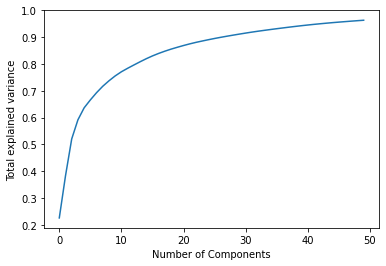

[0.22615058 0.15715984 0.13744073 0.07121294 0.04467293 0.02948856
 0.02704819 0.02394841 0.02034318 0.01822929 0.0154623  0.01292534
 0.01224393 0.0119864  0.01145319 0.01047321 0.00933997 0.00836004
 0.00764305 0.00687256 0.00656147 0.00613062 0.00557941 0.00503914
 0.00487149 0.00464486 0.00436713 0.00412562 0.00399369 0.00386558
 0.00373987 0.00362128 0.00337717 0.00318218 0.00311037 0.00301267
 0.00293455 0.00288003 0.00276782 0.00268098 0.00253258 0.0024309
 0.00224113 0.00214039 0.00207289 0.00190917 0.0018303  0.00179363
 0.00171184 0.00165912]


In [17]:


features_pca = decomposition.PCA(n_components=50)
features_pca.fit(x_train_dum)
plt.figure()
plt.plot(np.cumsum(features_pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Total explained variance')
plt.show()

print(features_pca.explained_variance_ratio_)

從上圖可以看出大約在PCA=20時，保留的variance成長趨勢漸趨平緩，因此接下來的modeling會使用PCA=20的維度

下圖嘗試用PCA1和PCA2畫散佈圖

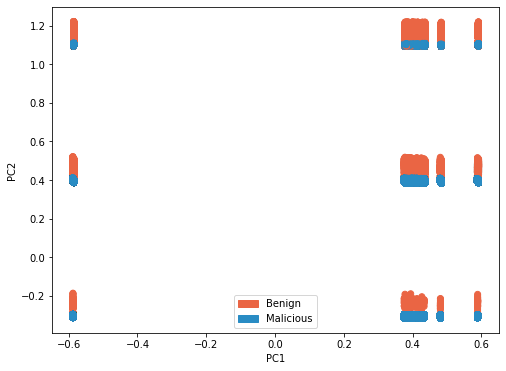

In [18]:
fig = plt.figure(figsize=(8,6))


features_pca = decomposition.PCA(n_components=2)
features_pca.fit(x_train_dum)
X_pca = features_pca.transform(x_train_dum)
colormap = np.array(['#EA6544', '#298CC4'])

plt.scatter(X_pca[:,0], X_pca[:,1], c = colormap[y_train])

good_lab = mpatches.Patch(color='#EA6544', label='Benign')
bad_lab = mpatches.Patch(color='#298CC4', label='Malicious')

plt.legend(handles=[good_lab, bad_lab])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

使testing data的columns和training data一樣

In [0]:
for col in x_train_dum.columns:
  if col not in x_test_dum.columns:
    x_test_dum[col] = 0

for col in x_test_dum.columns:
  if col not in x_train_dum.columns:
    x_test_dum = x_test_dum.drop([col], axis=1)

In [0]:
features_pca = decomposition.PCA(n_components=20)
features_pca.fit(x_train_dum)

x_train_dum_pca = features_pca.transform(x_train_dum)
x_test_dum_pca = features_pca.transform(x_test_dum)


### Model and Accuracy

#### KNN

In [21]:
# KNN

clf = KNeighborsClassifier(n_neighbors = 5, algorithm = 'auto')
clf.fit(x_train_dum_pca, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [22]:
y_pred = clf.predict(x_test_dum_pca)
# acc = clf.score(x_test_dum_pca, y_test)
# print("ACC: {}.".format(round(acc,4)))
print("KNN Accuracy: ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

KNN Accuracy:  0.9988727226510911
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8062
           1       1.00      1.00      1.00    353872

    accuracy                           1.00    361934
   macro avg       1.00      0.98      0.99    361934
weighted avg       1.00      1.00      1.00    361934

[[  7700    362]
 [    46 353826]]


#### Random Forest

In [23]:

rfc = RandomForestClassifier()
rfc.fit(x_train_dum_pca, y_train)

rfc_pred = rfc.predict(x_test_dum_pca)
print('Random Forest accuracy: ', accuracy_score(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))
print(confusion_matrix(y_test, rfc_pred))

Random Forest accuracy:  0.9988229898268746
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8062
           1       1.00      1.00      1.00    353872

    accuracy                           1.00    361934
   macro avg       0.99      0.98      0.99    361934
weighted avg       1.00      1.00      1.00    361934

[[  7716    346]
 [    80 353792]]


### Random Undersampling Data


In [24]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(x_train_dum_pca, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
y_resampled.size

54506

#### KNN

In [26]:
clf = KNeighborsClassifier(n_neighbors = 5, algorithm = 'auto')
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(x_test_dum_pca)
# acc = clf.score(x_test_dum_pca, y_test)
# print("ACC: {}.".format(round(acc,4)))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.997060237501865
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      8062
           1       1.00      1.00      1.00    353872

    accuracy                           1.00    361934
   macro avg       0.94      0.99      0.97    361934
weighted avg       1.00      1.00      1.00    361934

[[  7993     69]
 [   995 352877]]


#### Random Forest

In [27]:
rfc = RandomForestClassifier()
rfc.fit(X_resampled, y_resampled)

rfc_pred = rfc.predict(x_test_dum_pca)
print('Random Forest accuracy: ', accuracy_score(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))
print(confusion_matrix(y_test, rfc_pred))

Random Forest accuracy:  0.9905562892682092
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      8062
           1       1.00      0.99      1.00    353872

    accuracy                           0.99    361934
   macro avg       0.85      0.99      0.91    361934
weighted avg       0.99      0.99      0.99    361934

[[  8024     38]
 [  3380 350492]]


### Neural Network Model


In [0]:
model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[
                keras.metrics.TruePositives(name='tp'),
                keras.metrics.FalsePositives(name='fp'),
                keras.metrics.TrueNegatives(name='tn'),
                keras.metrics.FalseNegatives(name='fn'), 
                keras.metrics.BinaryAccuracy(name='accuracy'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc'),
                ])


In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True) 
model.fit(x_train_dum_pca, y_train, epochs=10, callbacks=[early_stop])

Epoch 1/10
37500/37500 [==============================] - 152s 4ms/step - loss: 0.3230 - tp: 1172693.0000 - fp: 1664.0000 - tn: 25589.0000 - fn: 54.0000 - accuracy: 0.9986 - precision: 0.9986 - recall: 1.0000 - auc: 0.9742
Epoch 2/10
37500/37500 [==============================] - 152s 4ms/step - loss: 0.3227 - tp: 1172746.0000 - fp: 1412.0000 - tn: 25841.0000 - fn: 1.0000 - accuracy: 0.9988 - precision: 0.9988 - recall: 1.0000 - auc: 0.9741
Epoch 3/10
37500/37500 [==============================] - 148s 4ms/step - loss: 0.3227 - tp: 1172747.0000 - fp: 1407.0000 - tn: 25846.0000 - fn: 0.0000e+00 - accuracy: 0.9988 - precision: 0.9988 - recall: 1.0000 - auc: 0.9742
Epoch 4/10
37500/37500 [==============================] - 146s 4ms/step - loss: 0.3227 - tp: 1172747.0000 - fp: 1407.0000 - tn: 25846.0000 - fn: 0.0000e+00 - accuracy: 0.9988 - precision: 0.9988 - recall: 1.0000 - auc: 0.9742
Epoch 5/10
37500/37500 [==============================] - 144s 4ms/step - loss: 0.3227 - tp: 1172747.00

In [0]:
# test_loss, test_acc = model.evaluate(x_test_dum_pca,  y_test, verbose=2)